# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Leemos los datos de enero 2020 (entrenamiento)

In [2]:
taxi = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')

In [3]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [4]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Descripción del Dataset

El diccionario de los datos puede encontrarse [acá](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):

| Field Name      | Description |
| ----------- | ----------- |
| VendorID      | A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.       |
| tpep_pickup_datetime   | The date and time when the meter was engaged.        |
| tpep_dropoff_datetime   | The date and time when the meter was disengaged.        |
| Passenger_count   | The number of passengers in the vehicle. This is a driver-entered value.      |
| Trip_distance   | The elapsed trip distance in miles reported by the taximeter.      |
| PULocationID   | TLC Taxi Zone in which the taximeter was engaged.      |
| DOLocationID   | TLC Taxi Zone in which the taximeter was disengaged      |
| RateCodeID   | The final rate code in effect at the end of the trip. 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride     |
| Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip |
| Payment_type | A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip |
| Fare_amount | The time-and-distance fare calculated by the meter. |
| Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| Improvement_surcharge | \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| Tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip. |
| Total_amount | The total amount charged to passengers. Does not include cash tips. |

## Definimos las características con las que realizaremos la clasificación.

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [5]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [6]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [7]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [8]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.3574348 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda:

`taxi_train = taxi_train.head(100000)`

In [9]:
taxi_train = taxi_train.head(100000)
taxi_train

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-01-01 00:33:03,2.0,0.0,0.0,28.0,1.0,1.20,288.0,0.004167,238.0,239.0,1.0,1
1,2020-01-01 00:43:04,2.0,0.0,0.0,35.0,1.0,1.20,445.0,0.002697,239.0,238.0,1.0,1
2,2020-01-01 00:53:52,2.0,0.0,0.0,47.0,1.0,0.60,371.0,0.001617,238.0,238.0,1.0,0
3,2020-01-01 01:00:14,2.0,0.0,0.0,55.0,1.0,0.80,291.0,0.002749,238.0,151.0,1.0,1
4,2020-01-01 00:04:16,2.0,0.0,0.0,1.0,1.0,0.00,138.0,0.000000,193.0,193.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-01-01 14:05:18,2.0,14.0,1.0,2.0,1.0,0.67,172.0,0.003895,262.0,140.0,1.0,0
99996,2020-01-01 14:19:09,2.0,14.0,1.0,13.0,1.0,0.94,345.0,0.002725,229.0,237.0,1.0,0
99997,2020-01-01 14:27:52,2.0,14.0,1.0,21.0,2.0,0.96,359.0,0.002674,237.0,140.0,1.0,1
99998,2020-01-01 14:36:05,2.0,14.0,1.0,33.0,1.0,0.69,141.0,0.004894,237.0,263.0,1.0,0


In [10]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

CPU times: user 12.7 s, sys: 31.6 ms, total: 12.7 s
Wall time: 15.7 s


RandomForestClassifier(max_depth=10)

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [11]:
%%time
# Compute F1
preds = rfc.predict_proba(taxi_train[features])

CPU times: user 1.22 s, sys: 5.01 ms, total: 1.23 s
Wall time: 1.27 s


In [12]:
preds

array([[0.39637373, 0.60362627],
       [0.40158705, 0.59841295],
       [0.48753415, 0.51246585],
       ...,
       [0.46035836, 0.53964164],
       [0.39541593, 0.60458407],
       [0.44012371, 0.55987629]])

In [13]:
preds_labels = [p[1] for p in preds.round()]

In [14]:
preds_labels[0:10]

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
print(f'F1: {f1_score(taxi_train[target_col], preds_labels)}')

F1: 0.6557721406319537


## Exportamos el modelo a un archivo

In [16]:
import joblib

joblib.dump(rfc, "random_forest.joblib")

['random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

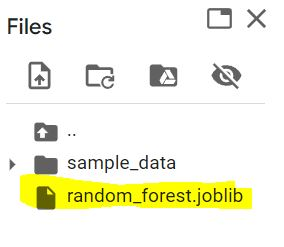

## Cargamos los datos de febrero 2020 (prueba)

In [17]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [18]:
loaded_rfc = joblib.load("random_forest.joblib")

In [19]:
%%time
# Compute F1
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: user 1min 1s, sys: 154 ms, total: 1min 1s
Wall time: 1min 2s


In [20]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.36130598985927614


## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [21]:
taxi_test.head(1)[features].iloc[0].values

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [22]:
taxi_test.head(1)[target_col].iloc[0]

1

In [23]:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5460635174428677

## Motivación: calculemos el desempeño para mayo de 2020

In [24]:
taxi_may= pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')
taxi_test = preprocess(taxi_may, target_col=target_col)
taxi_test.head()

preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')


F1: 0.5163927324618404


# ESTRATEGIA

La estrategia para demostrar el comportamiento distinto del modelo para los meses de enero y febrero se basa en tres pasos clave: análisis descriptivo, entrenamiento y evaluación cruzada del modelo, y análisis de la importancia de las características.


### Resultados y Observaciones
1- Análisis Descriptivo: Se observaron diferencias en las distribuciones de varias características entre enero y febrero, indicando una variabilidad significativa en los datos.

2- Evaluación del Modelo: El F1-score varió dependiendo del mes de entrenamiento y prueba, sugiriendo que el modelo entrenado en febrero tuvo un mejor rendimiento generalizado que el entrenado en enero.

3- Importancia de Características: Aunque las características más importantes fueron consistentes entre los meses, su orden de importancia varió ligeramente, indicando posibles diferencias en los patrones subyacentes de cada mes.

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [27]:
# Cargando los datos de enero 2020 (entrenamiento)
taxi_jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')

# Definiendo las características
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

def preprocess(df, target_col):
    # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)

target_col = "high_tip"

taxi_train_jan = preprocess(df=taxi_jan, target_col=target_col)
taxi_train_feb = preprocess(df=taxi_feb, target_col=target_col)

# Limitamos el tamaño del conjunto de entrenamiento
taxi_train_jan = taxi_train_jan.head(100000)
taxi_train_feb = taxi_train_feb.head(100000)


Análisis descriptivo para Enero



,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,2020-01-01 04:16:19.587930,1.998750,5.448300,0.353430,29.575760,1.655840,3.361403,1037.011230,2.940045e+02,155.360565,152.689209,1.088170,0.507390
min,2009-01-01 00:51:18,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,1.000000,0.000000
25%,2020-01-01 02:01:23,2.000000,1.000000,0.000000,15.000000,1.000000,1.100000,355.000000,2.736145e-03,100.000000,88.000000,1.000000,0.000000
50%,2020-01-01 04:04:02,2.000000,3.000000,0.000000,30.000000,1.000000,2.000000,612.000000,3.557453e-03,152.000000,151.000000,1.000000,1.000000
75%,2020-01-01 11:17:47,2.000000,11.000000,1.000000,44.000000,2.000000,4.000000,1014.000000,4.747090e-03,231.000000,231.000000,1.000000,1.000000
max,2020-01-02 14:49:29,3.000000,23.000000,1.000000,59.000000,9.000000,100.150002,86376.000000,2.900000e+07,265.000000,265.000000,99.000000,1.000000
std,NaN,0.035895,4.812498,0.478037,17.180586,1.213832,3.899145,4930.377441,9.171476e+04,70.339134,74.281082,1.246568,0.499948


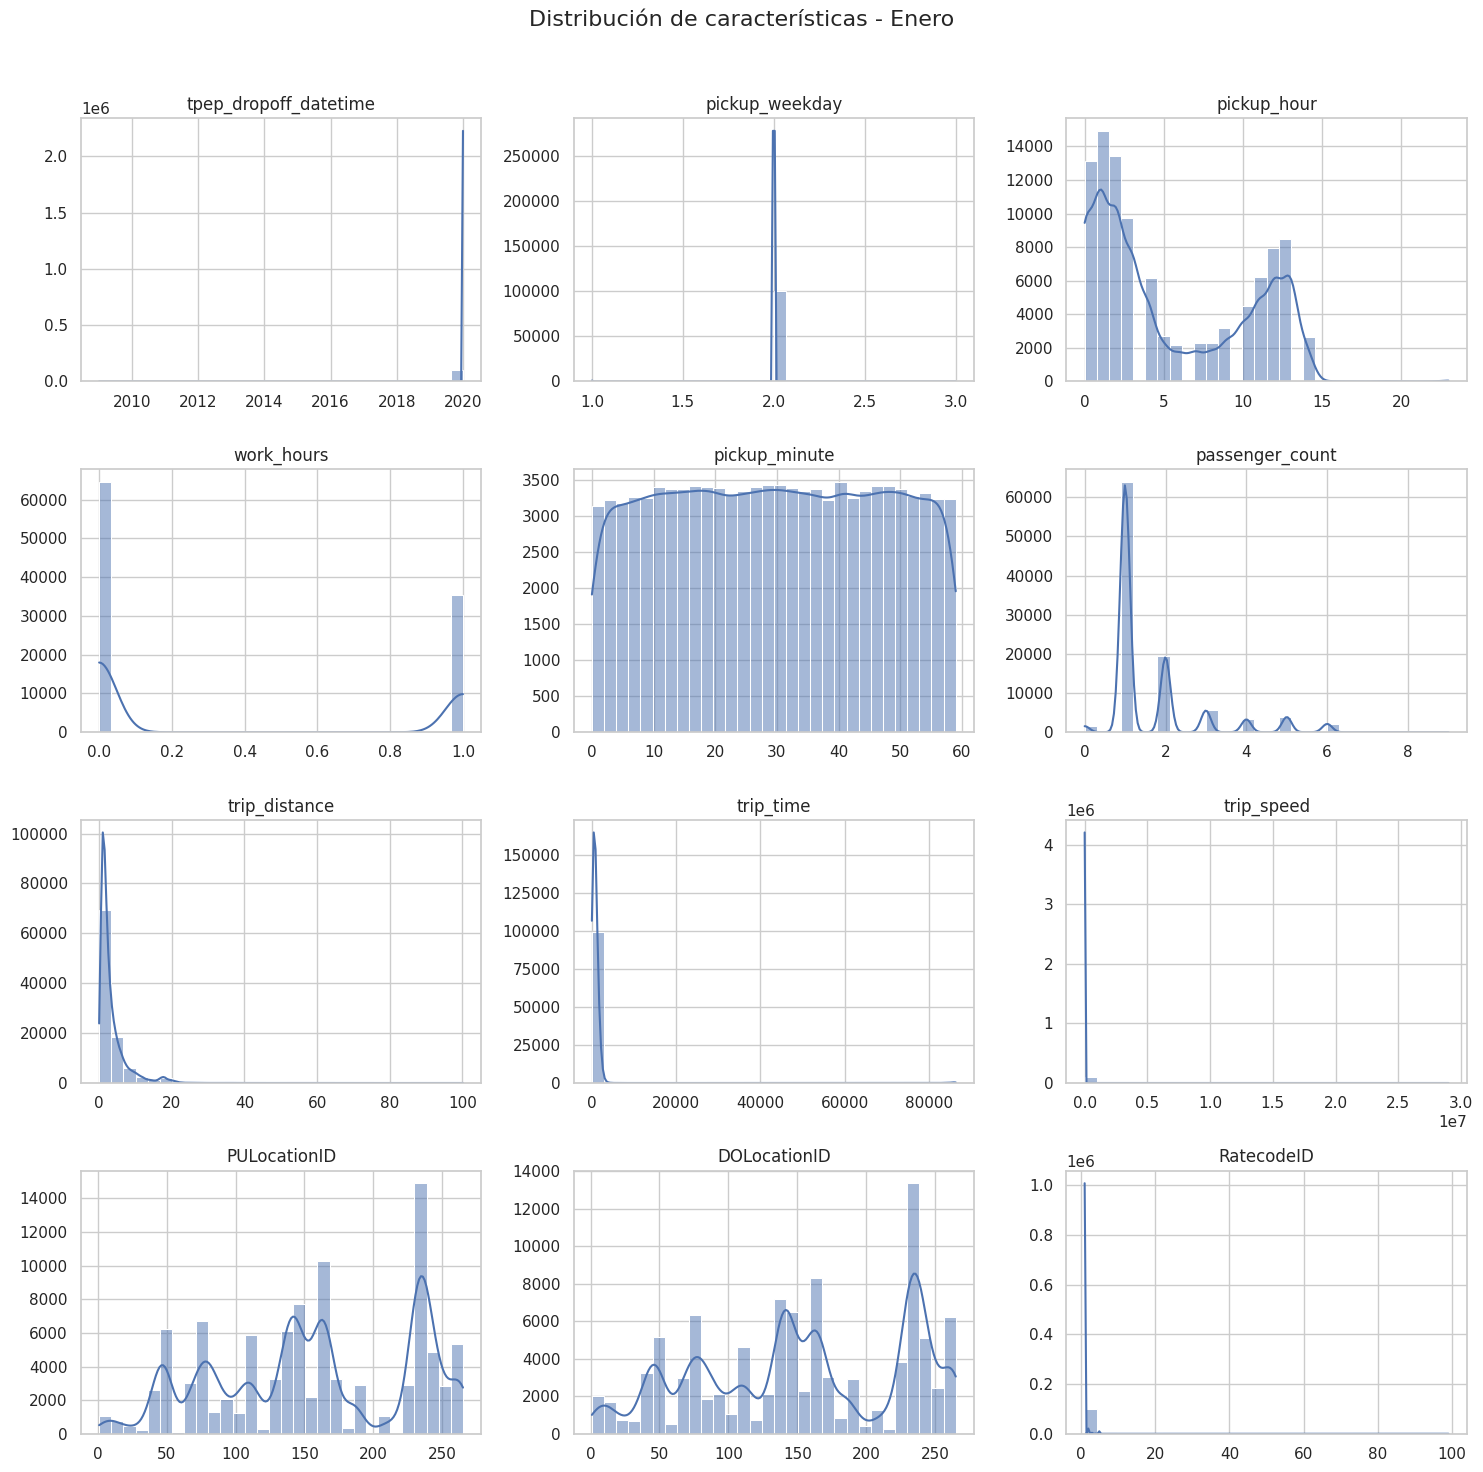

Análisis descriptivo para Febrero



,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2020-02-01 08:36:44.159770,4.997720,7.921540,0.000350,29.795290,1.553340,2.730078,866.368958,0.004009,160.689728,159.773087,1.048150,0.560610
min,2020-01-30 10:59:14,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2020-02-01 03:20:28.750000,5.000000,3.000000,0.000000,15.000000,1.000000,1.000000,339.000000,0.002538,107.000000,107.000000,1.000000,0.000000
50%,2020-02-01 10:07:56,5.000000,9.000000,0.000000,30.000000,1.000000,1.650000,549.000000,0.003223,158.000000,161.000000,1.000000,1.000000
75%,2020-02-01 12:40:29,5.000000,12.000000,0.000000,45.000000,2.000000,2.980000,865.000000,0.004222,234.000000,234.000000,1.000000,1.000000
max,2020-02-02 14:44:33,5.000000,23.000000,1.000000,59.000000,6.000000,55.200001,86359.000000,6.066667,265.000000,265.000000,99.000000,1.000000
std,NaN,0.047904,4.828726,0.018705,17.424543,1.187135,3.327326,4098.300781,0.031063,68.472443,71.897842,0.557292,0.496315


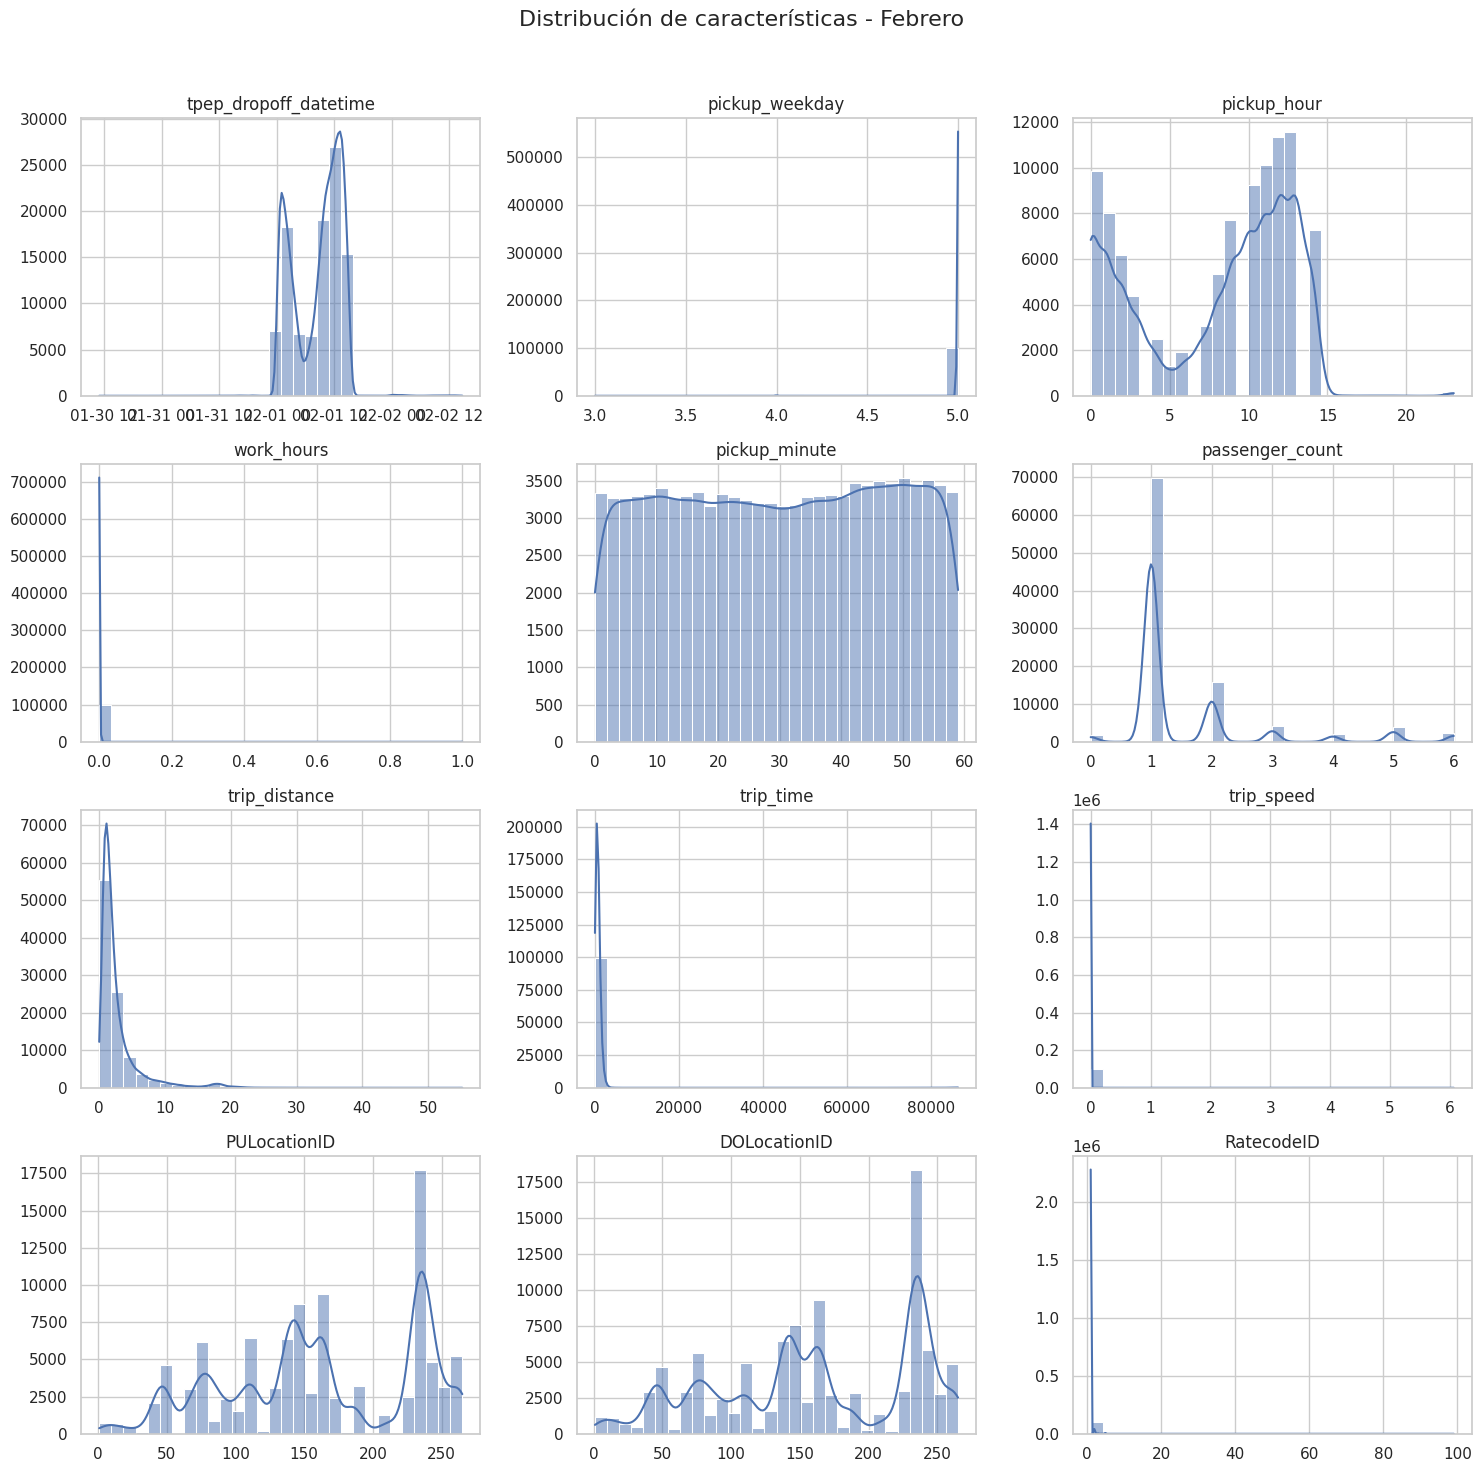

In [33]:
import seaborn as sns


# Configuración de estilo para gráficos
sns.set(style="whitegrid")

def descriptive_analysis(data, month):
    print(f"Análisis descriptivo para {month}\n")

    # Estadísticas descriptivas
    descriptive_stats = data.describe()
    display(descriptive_stats)

    # Gráficos de distribución
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
    fig.suptitle(f"Distribución de características - {month}", fontsize=16)

    for ax, column in zip(axes.flatten(), data.columns):
        sns.histplot(data[column], bins=30, kde=True, ax=ax)
        ax.set_title(column)
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Análisis descriptivo para enero y febrero
descriptive_analysis(taxi_train_jan, 'Enero')
descriptive_analysis(taxi_train_feb, 'Febrero')

In [29]:
# Entrenamiento y evaluación mensual
def train_evaluate_monthly(train_data, test_data, month_train, month_test):
    X_train = train_data[features]
    y_train = train_data[target_col]
    X_test = test_data[features]
    y_test = test_data[target_col]

    model = RandomForestClassifier(n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    print(f"F1-score al entrenar con {month_train} y evaluar con {month_test}: {f1}")

    return model

# Entrenamiento y evaluación cruzada
model_jan = train_evaluate_monthly(taxi_train_jan, taxi_train_feb, 'Enero', 'Febrero')
model_feb = train_evaluate_monthly(taxi_train_feb, taxi_train_jan, 'Febrero', 'Enero')


F1-score al entrenar con Enero y evaluar con Febrero: 0.5138445487741263
F1-score al entrenar con Febrero y evaluar con Enero: 0.6615394081092721


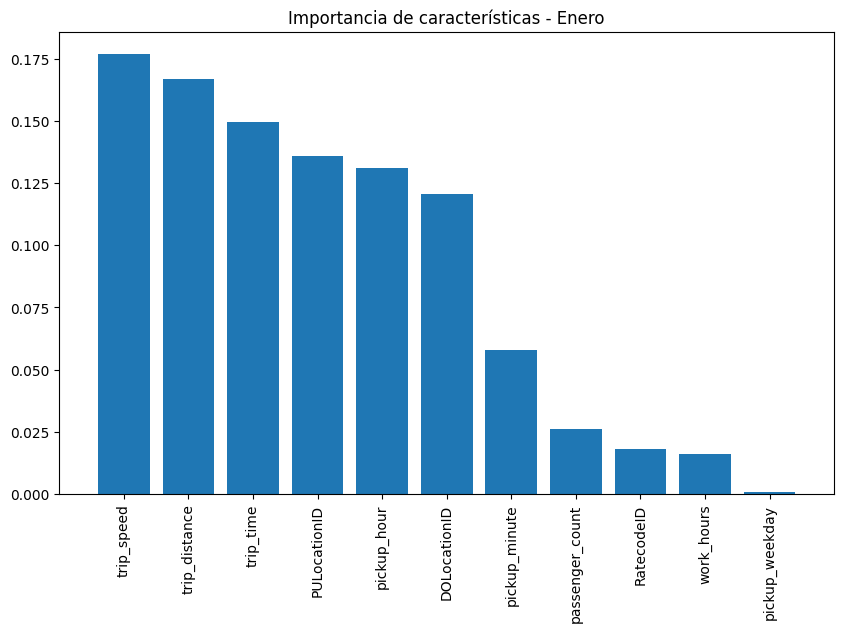

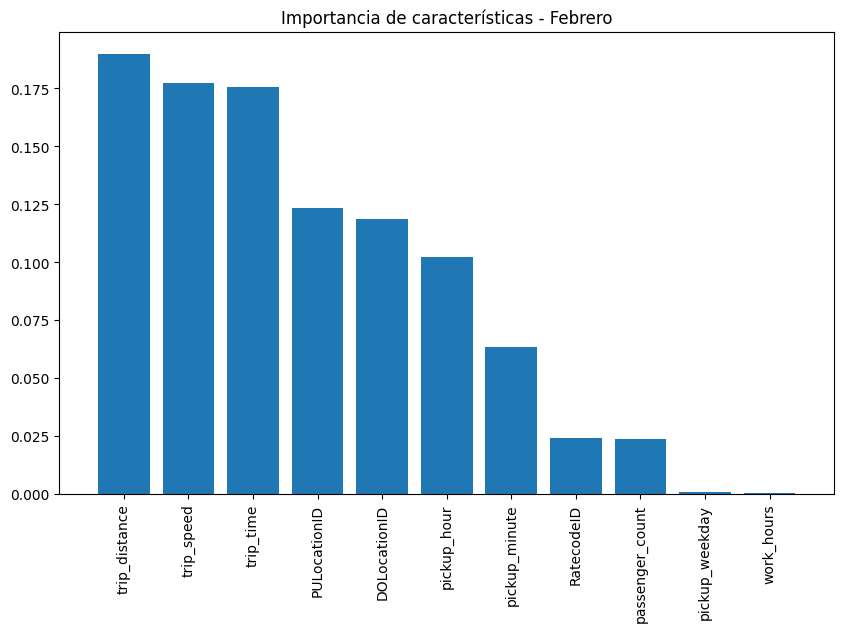

In [31]:
# Analisis de importancia de características
def feature_importance_analysis(model, month):
    importances = model.feature_importances_
    feature_names = np.array(features)  # Convertimos a numpy array
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Importancia de características - {month}")
    plt.bar(range(len(feature_names)), importances[indices], align='center')
    plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
    plt.xlim([-1, len(feature_names)])
    plt.show()

# Analisis de importancia de características
feature_importance_analysis(model_jan, 'Enero')
feature_importance_analysis(model_feb, 'Febrero')



# Conclusión

El análisis demuestra que el modelo tiene un comportamiento distinto para cada mes, influenciado por la variabilidad en las características de los datos. Este enfoque permite entender mejor cómo y por qué el desempeño del modelo puede cambiar con el tiempo, proporcionando información valiosa para mejorar la robustez y generalización del modelo en el futuro.

